# Sentiment Analysis of Product Reviews

## Topics

1.0 Importing packages and loading data

    1.1 About the dataset
    
    1.2 Loading the dataset

    1.3 Exploratory Data Analysis (EDA)

2.0 Cleaning text for analysis

3.0 Plotting the wordcloud using TfIdf Vectorizer

4.0 Running different ML models

    4.1 Naive Baye's Classifier
    
    4.2 Logistic Regression Classifier
    
    4.3 CNN
    
    4.4 RNN using LSTM

5.0 Interpreting the results

## 1.0 Importing packages and loading data

Import all the packages and load the required data from tensorflow datasets of amazon_reviews of watches.

In [ ]:
import tensorflow
import tensorflow_datasets as tfds
from textblob import TextBlob
from tensorflow import keras
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### 1.1 About the dataset
This is a dataset of amazon reviews of watches collected from amazon with the official rights.

A repository of 1.8 million reviews, with relevant features such as customer_id, category, product_id, product_title, review_body, review_headline, star_rating, and more.

### 1.2 Loading the dataset
The downloaded data is in zip file of train and test, and we will be working on the train set.

In [ ]:
ds_watch = tfds.load('amazon_us_reviews/Watches_v1_00', split='train', shuffle_files= True)
ds_watch

In [ ]:
df_watch = tfds.as_dataframe(ds_watch.take(10000))
df_watch

In [ ]:
df_watch.columns

In [ ]:
df_watch.info()

In [ ]:
df_watch_new = df_watch[['data/review_body', 'data/review_headline', 'data/star_rating']]
df_watch_new

In [ ]:
df_watch_new.isnull().sum()

In [ ]:
sns.boxplot(df_watch_new["data/star_rating"])

In [ ]:
q1 = df_watch_new["data/star_rating"].quantile(0.25)
q3 = df_watch_new["data/star_rating"].quantile(0.75)
q1, q3

In [ ]:
iqr = q3-q1
iqr

In [ ]:
upper = q3 +1.5*iqr
lower = q1 - 1.5*iqr
upper, lower

All the texts are encoded in utf-8 format and needs to be decoded to use them.

In [ ]:
# https://stackoverflow.com/questions/40389764/how-to-translate-bytes-objects-into-literal-strings-in-pandas-dataframe-pytho
df_watch_new['data/review_body'] = df_watch_new['data/review_body'].str.decode("utf-8")
df_watch_new['data/review_headline'] = df_watch_new['data/review_headline'].str.decode("utf-8")
df_watch_new

In [ ]:
analyser = SentimentIntensityAnalyzer()
df_watch_new["polarity_scores"] = df_watch_new["data/review_body"].apply(analyser.polarity_scores)
df_watch_new

In [ ]:
def extracting_rating(polarity_scores):
    if polarity_scores >= -1.0 and polarity_scores < -0.6:
        return 1
    elif polarity_scores >= -0.6 and polarity_scores < -0.2:
        return 2
    elif polarity_scores >= -0.2 and polarity_scores < 0.2:
        return 3
    elif polarity_scores >= 0.2 and polarity_scores < 0.6:
        return 4
    elif polarity_scores >= 0.6 and polarity_scores <= 1.0:
        return 5

In [ ]:
df_watch_new['extracted_rating'] = df_watch_new['polarity_scores'].apply(lambda x: extracting_rating(x['compound']))
df_watch_new

#### We can see below the count of the new categories and the data looks dominating by 5 star ratings.

In [ ]:
print(df_watch_new.groupby(['extracted_rating']).size())
print(df_watch_new.groupby(['data/star_rating']).size())
df_watch_new.groupby(['extracted_rating']).size().plot(kind = "bar")

In [ ]:
df_watch_new.groupby(['data/star_rating']).size().plot(kind = "bar")

As we can see from above that the actual rating of the reviews lokks not to b that correct when compared to the sentiment taht is expressed in the text review.

## 2.0 Cleaning text for analysis

All the important steps of cleaning the text are performed in the API clean_text.

1. Lower the text
2. Cleaning the words to remove unwanted characters(important step)
3. Stop words removal
4. Remove lengthening of words
5. Perform Lemmatization
6. Perform stemming

In [ ]:
def convert_to_lower(text):
    # Convert words to lower case
    return text.lower()
    
def format_words_remove_unwanted_chars(text):
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', ' ', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    # <br and > have been done separately because they are getting treated as different words rather than a single tag
    text = re.sub(r'<br ', ' ', text)
    text = re.sub(r'>', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\\\\', ' ', text)
    text = re.sub(r'<p><br [\/]?><[\/]?p>', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub("[^a-zA-Z]+", " ",text)
    return text
    
def remove_stopwords(text):  
    # Removing stop words
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops]
    return text

def remove_lengthening(text):
    # Remove Lengthening
    patt = re.compile(r"(.)\1{2,}")
    length_list = [patt.sub(r"\1",word) for word in text]
    return length_list
    
def lemmatizing(text):
    # Lemmatizer
    lem = WordNetLemmatizer()
    lem_list = [lem.lemmatize(word) for word in text]
    return lem_list

def stemming(text):
    # Stemming
    porter = PorterStemmer()
    stem_list = [porter.stem(word) for word in text]
    stem_list = list(dict.fromkeys(stem_list))
    return " ".join(stem_list)

Below piece of code will perform all the data cleaning operations and give us a cleaned text which is added as a new column.

In [ ]:
df_watch_new['clean_review'] = df_watch_new['data/review_body'].apply(lambda x: convert_to_lower(x))
df_watch_new['clean_review'] = df_watch_new['clean_review'].apply(lambda x: format_words_remove_unwanted_chars(x))
df_watch_new['clean_review'] = df_watch_new['clean_review'].apply(lambda x: remove_stopwords(x))
#df_watch_new['clean_review'] = df_watch_new['clean_review'].apply(lambda x: remove_lengthening(x))
df_watch_new['clean_review'] = df_watch_new['clean_review'].apply(lambda x: lemmatizing(x))
df_watch_new['clean_review'] = df_watch_new['clean_review'].apply(lambda x: stemming(x))
df_watch_new

In [ ]:
nltk.FreqDist(df_watch_new['clean_review'])

## 3.0 Plotting the wordcloud using TfIdf Vectorizer
Making a WordCloud of the vocabulary extracted from the cleaned abstracts using the Tf-Idf vectorizer.
#### Tf-Idf Vectorizer:
Term frequency-inverse document frequency (tf-idf) gives a measure that takes the importance of a word in consideration depending on how frequently it occurs in a document and a corpus.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_watch_new['clean_review'])
column_names = vectorizer.get_feature_names()
df1 = pd.DataFrame(X.toarray(), columns = column_names, index = df_watch_new['clean_review'])
df1

In [ ]:
X_mat = X.toarray()
docs = X_mat[(X_mat>0).any(axis=1)]
words = np.array(column_names)

In [ ]:
frequencies={}
for i in range(len(docs)):
    doc = docs[i] 
    idx = (doc>0)
    doc_words = words[idx]
    doc_counts = doc[doc>0]
    dict1 = dict(zip(doc_words, doc_counts))
    frequencies.update(dict1)
frequencies

In [ ]:
wordcloud = WordCloud(background_color='white').fit_words(frequencies)
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")
fig.savefig("tfidfvect_wordcloud.png", bbox_inches = 'tight', pad_inches = 0)

## 4.0 Running different ML models
Splitting the dataset into training and testing set.

In [ ]:
# 80 and 20 ratio
X_train, X_test, y_train, y_test = train_test_split(df_watch_new["clean_review"], df_watch_new["data/star_rating"], stratify=df_watch_new["data/star_rating"], random_state=1234, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### 4.1 Naive Baye's Classifier
A naive Bayes classifier is an algorithm for classifying objects that employs Bayes' theorem. Naive Bayes classifiers are based on the assumption of strong (or naive) independence between data point attributes.

We will be running our train and test on Naive Baye's model and measure the accuracy, f1 score, precision, recall, and roc_auc score.

In [ ]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()
# fit
vectorizer.fit(X_train)
# transform training data
X_train_dtm = vectorizer.transform(X_train)
# equivalently: combine fit and transform into a single step
# this is faster and what most people would do
X_train_dtm = vectorizer.fit_transform(X_train)
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vectorizer.transform(X_test)
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
# using X_train_dtm
%time nb.fit(X_train_dtm, y_train)
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)
# calculate accuracy of class predictions
print(classification_report(y_test, y_pred_class))

In [ ]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

### 4.2 Logistic Regression Classifier
Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable. The nature of target or dependent variable is dichotomous, which means there would be only two possible classes.

We will be running our train and test on Logistic Regression model and measure the accuracy, f1 score, precision, recall, and roc_auc score.

the performance of the Logistice Regression Classifier is mostly better when comapre dto the Naive Baye's but it is lot slower when compared to it as well.

In [ ]:
# instantiate a logistic regression model
logreg = LogisticRegression()
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
# calculate accuracy of class predictions
print(classification_report(y_test, y_pred_class))

In [ ]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

In [ ]:
def binary(rating):
    if rating > 3:
        return 1
    else:
        return 0

In [ ]:
df_watch_new[["binary_rating"]] = df_watch_new["data/star_rating"].apply(lambda i: binary(i))
df_watch_new

### 4.3 CNN


We will be now splitting the train dataset into train and validation sets for training on the Neural Network models.

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(X_train, y_train, stratify= y_train, random_state=57643892, test_size=0.2)
print(train_texts.shape)
print(val_texts.shape)
print(train_labels.shape)
print(val_labels.shape)

In [ ]:
train_texts

Keras includes some tools for converting text to formats that deep learning models can use. I've already done some processing, so all that remains is for me to run a Tokenizer with the top 12000 words as features.

In [ ]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(X_test)

#### Padding Sequences
To effectively use batches, I'll need to convert my sequences into sequences of the same length. Everything here will be the length of the longest sentence in the training set. I'm not dealing with it here, but having variable lengths may be advantageous so that each batch contains sentences of similar lengths. This may help to alleviate problems caused by too many padded elements in a sequence. Padding modes are also available, which may be useful for different models.

In [ ]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

#### Convolutional Neural Net Model
Here, I'm just using some basic models. This CNN has a 64-dimensional embedding, three convolutional layers, the first two of which have max pooling and the last of which has global max pooling. The results are then routed through a dense layer and finally to the output.

In [ ]:
metrics = [keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]
def build_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model
    
model = build_model()
model.summary()

In [ ]:
%time model.fit(train_texts, train_labels, batch_size=128, epochs=2, validation_data=(val_texts, val_labels))

In [ ]:
%time model.fit(train_texts, train_labels, batch_size=128, epochs=2, validation_split = 0.2)

In [ ]:
preds = model.predict(test_texts)
metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test,preds)
print('Categorical accuracy score: {:0.4}'.format(metric.result().numpy()))
metric = keras.metrics.Precision()
metric.update_state(y_test,preds)
print('Precision: {:0.4}'.format(metric.result().numpy()))
metric = keras.metrics.Recall()
metric.update_state(y_test,preds)
print('Recall: {:0.4}'.format(metric.result().numpy()))

### 4.4 RNN
#### Recurrent Neural Net Model
I'm going to use a simple model for an RNN model as well. This is made up of an embedding, two LSTM layers, two dense layers, and the output layer. Because the latter require GPU, I'm using the LSTM rather than the GRU/CuDNNGRU.

In [ ]:
def build_rnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.LSTM(128, return_sequences=True)(embedded)
    x = layers.LSTM(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model
    
rnn_model = build_rnn_model()
rnn_model.summary()

In [ ]:
%time rnn_model.fit(train_texts, train_labels, batch_size=128, epochs=1, validation_data=(val_texts, val_labels))

In [ ]:
preds = rnn_model.predict(test_texts)
metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test,preds)
print('Categorical accuracy score: {:0.4}'.format(metric.result().numpy()))
metric = keras.metrics.Precision()
metric.update_state(y_test,preds)
print('Precision: {:0.4}'.format(metric.result().numpy()))
metric = keras.metrics.Recall()
metric.update_state(y_test,preds)
print('Recall: {:0.4}'.format(metric.result().numpy()))

## 5.0 Interpreting the results


As we try the deep learning models the results are exceptional but the run time is very high as shown in the table below.
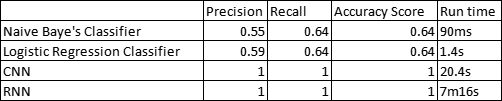

#### What else could we do?
I haven't tried a lot of things here. Other fields from the original Amazon data, I believe, could be added to the model. Furthermore, we did not include any global features from the samples, such as length, character level features, and so on. We could even try character-level deep learning models to see if they can reduce sensitivity to misspellings. Character level characteristics may be important in online reviews because users may misspell things to avoid moderation. However, because these models are already performing near-perfectly, any gains will be minimal at this point.